#Text Summarization with Transformers

### Problem. Given a news article (long text), generate a concise abstractive summary that captures the main points.

In [1]:
# Colab cell 1 — install dependencies
!pip install -q transformers datasets evaluate rouge_score sentencepiece accelerate


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [2]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import numpy as np
import random
import torch

print("torch:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


torch: 2.9.0+cu126
device: cuda


In [3]:
MODEL_NAME = "facebook/bart-large-cnn"   # or "t5-base" / "t5-small"
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")  # stable variant
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


=== SAMPLE 0
Article (truncated): LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18,
Highlights: Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earn

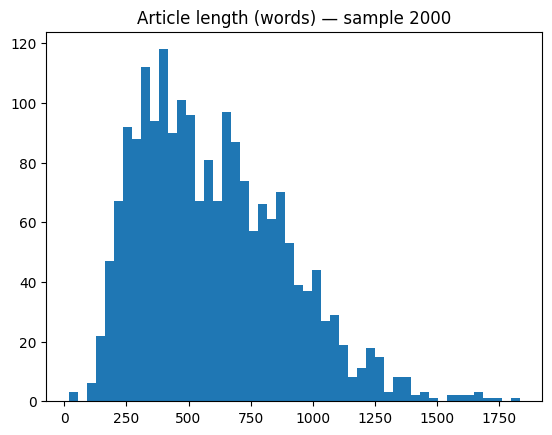

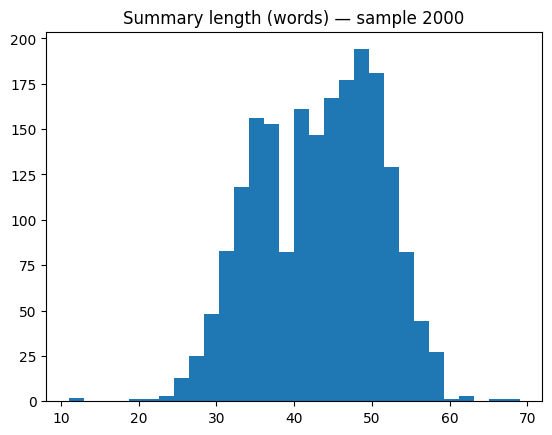

In [4]:
for i in range(2):
    print("=== SAMPLE", i)
    print("Article (truncated):", dataset['train'][i]['article'][:800].replace("\n"," "))
    print("Highlights:", dataset['train'][i]['highlights'])
    print()

# Check length distributions (article and summary)
import matplotlib.pyplot as plt
article_lens = [len(x['article'].split()) for x in dataset['train'].select(range(2000))]
summary_lens = [len(x['highlights'].split()) for x in dataset['train'].select(range(2000))]

plt.hist(article_lens, bins=50)
plt.title("Article length (words) — sample 2000")
plt.show()
plt.hist(summary_lens, bins=30)
plt.title("Summary length (words) — sample 2000")
plt.show()


In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# choose suitable max lengths based on earlier histograms
MAX_INPUT_LEN = 512
MAX_TARGET_LEN = 128

def preprocess_function(examples):
    inputs = examples['article']
    # normalization: collapse multiple newlines/spaces
    inputs = [" ".join(inp.split()) for inp in inputs]
    # T5-style prefix
    if "t5" in MODEL_NAME:
        inputs = ["summarize: " + inp for inp in inputs]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LEN, truncation=True)
    # targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['highlights'], max_length=MAX_TARGET_LEN, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# apply preprocessing to dataset (use batched mapping)
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
print(tokenized_datasets["train"].features)


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

{'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': List(Value('int64'))}


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
print(model.config)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
import transformers
print(transformers.__version__)


In [ ]:
from pathlib import Path

output_dir = "./bart_cnn_summ" if "bart" in MODEL_NAME else "./t5_cnn_summ"
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    predict_with_generate=True,
    logging_steps=500,
    save_steps=1000,
    eval_steps=1000,
    learning_rate=2e-5,
    num_train_epochs=1,
    fp16=torch.cuda.is_available(),
)


In [ ]:
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    # rouge expects newline-separated sentences — but for short summaries simple strip is fine
    return preds, labels

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in labels as tokenizer.pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Select ROUGE-L, ROUGE-1, ROUGE-2
    result = {k: round(v * 100, 4) for k, v in result.items()}
    # Add mean length
    result["gen_len"] = np.mean([len(tokenizer.encode(p)) for p in decoded_preds])
    return result


In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5, fused=False)
trainer.create_optimizer = lambda: optimizer


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_datasets["train"].select(range(20000)),   # use subset for demo
    eval_dataset=tokenized_datasets["validation"].select(range(2000)),
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


In [ ]:
import matplotlib.pyplot as plt
history = trainer.state.log_history
# extract train loss and eval rouge2
train_losses = [h["loss"] for h in history if "loss" in h]
eval_rouge2 = [h["eval_rouge2"] for h in history if "eval_rouge2" in h]
plt.plot(train_losses)
plt.title("Train Loss (per logging step)")
plt.show()
plt.plot(eval_rouge2)
plt.title("Eval ROUGE-2 (per eval step)")
plt.show()


In [ ]:
metrics = trainer.evaluate(tokenized_datasets["test"].select(range(1000)))
print("Eval metrics:", metrics)

# Sample predictions
test_samples = dataset["test"].select(range(5))
inputs = [" ".join(x.split()) for x in test_samples['article']]
if "t5" in MODEL_NAME:
    inputs = ["summarize: " + i for i in inputs]
batch = tokenizer(inputs, truncation=True, padding=True, max_length=512, return_tensors="pt").to(device)
with torch.no_grad():
    generated_ids = model.generate(**batch, max_length=120, num_beams=4, early_stopping=True)
preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
for i, p in enumerate(preds):
    print("=== ARTICLE", i)
    print(inputs[i][:500], "...\n")
    print("PRED:", p)
    print("REF:", test_samples['highlights'][i])
    print()


In [ ]:
# save
trainer.save_model("best_bart_model")
tokenizer.save_pretrained("best_bart_model")

# load later
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("best_bart_model")
model = AutoModelForSeq2SeqLM.from_pretrained("best_bart_model").to(device)
